## Campos involucrados

- tipodepropiedad
- antiguedad
- habitaciones
- banos
- metroscubiertos
- metrostotales


## Hipótesis

- En las zonas urbanas debería haber mayor cantidad de apartamentos que cualquier otro tipo de propiedad
- Si consideramos características similares los departamentos deberían ser más caros que las casas
- Las casas tienen más metros cuadrados que los departamentos (en general)
- El factor más importante para el precio de una vivienda son el tipo de propiedad y los metros cuadrados
- Las habitaciones y cantidad de baños deberían correlacionarse con la cantidad de metros.
- Las publicaciones de lugares comerciales deberían estar concentradas en lugares más céntricos


In [5]:
%run "../../utils/dataset_parsing.ipynb"
%run "../../utils/graphs.ipynb"
import seaborn as sns

publicaciones = levantar_datos("../../" + DATASET_RELATIVE_PATH)

## Porcentaje de publicaciones de cada tipo de propiedad en cada provincia
Se quiere saber qué es lo que más se publica en cada provincia. Seguramente la mayor cantidad de publicaciones sean de departamentos o casas. En centros urbanos muy poblados, como el distrito federal, seguramente haya mayor cantidad de publicaciones de departamentos, mientras que en zonas no tan urbanizadas la cantidad de publicaciones de casas sean predominantes.

In [6]:
#Se obtiene un dataframe con la cantidad de publicaciones de cada provincia
publicaciones_por_provincia = publicaciones.groupby('provincia').agg({'id':'count'})

In [7]:
publicaciones_por_provincia_y_tipo = publicaciones.groupby(['provincia', 'tipodepropiedad']).agg({'id':'count'}).reset_index()
publicaciones_por_provincia_y_tipo = pd.merge(publicaciones_por_provincia_y_tipo, publicaciones_por_provincia, on='provincia')
publicaciones_por_provincia_y_tipo = publicaciones_por_provincia_y_tipo.rename(columns={'id_x':'cantidad_tipo', 'id_y':'cantidad_total'})
publicaciones_por_provincia_y_tipo['porcentaje'] = publicaciones_por_provincia_y_tipo['cantidad_tipo'] / publicaciones_por_provincia_y_tipo['cantidad_total']
publicaciones_por_provincia_y_tipo = publicaciones_por_provincia_y_tipo.set_index(['provincia', 'tipodepropiedad'])

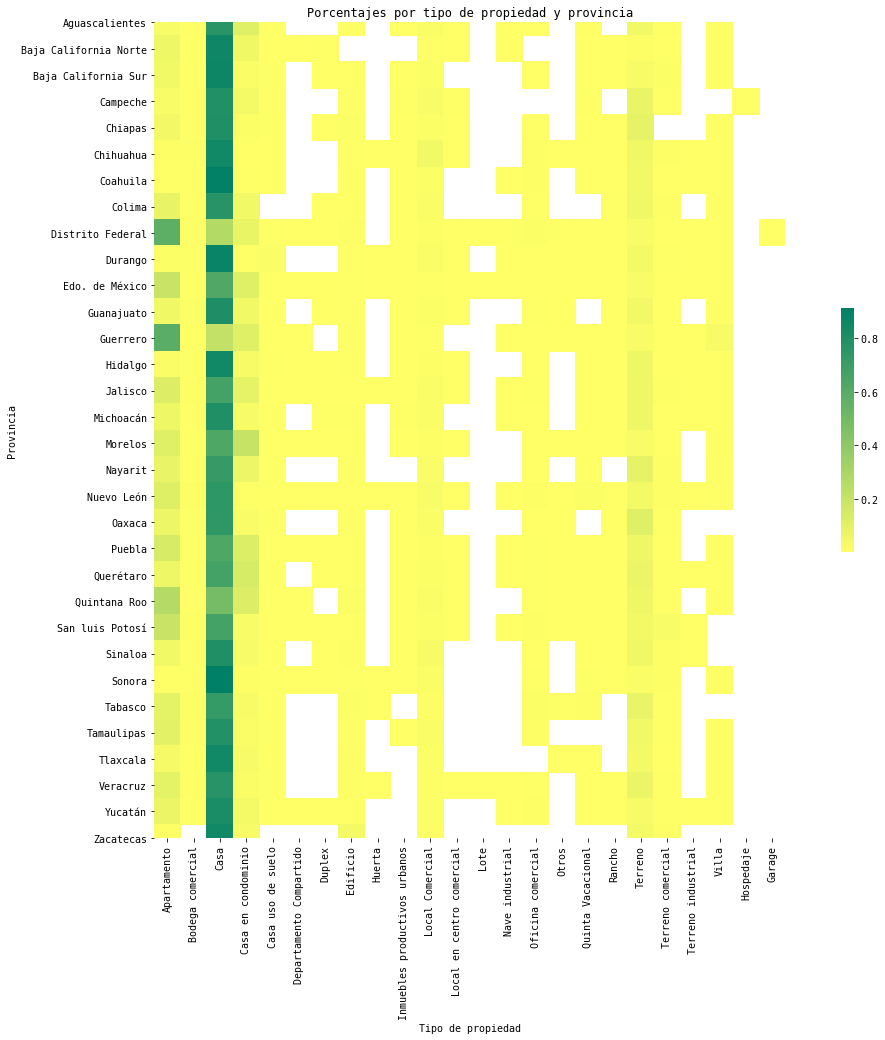

In [8]:
publicaciones_por_provincia_y_tipo_for_heatmap = publicaciones_por_provincia_y_tipo.pivot_table(index='provincia', columns='tipodepropiedad', values='porcentaje', aggfunc='sum')
get_heatmap(publicaciones_por_provincia_y_tipo_for_heatmap, xlabel="Tipo de propiedad", ylabel="Provincia", title="Porcentajes por tipo de propiedad y provincia")

#### Se puede visualizar en el heatmap que en general la cantidad de publicaciones de casas es muy grande, en relación con los demás tipos de propiedades.

Efectivamente en el distrito federal la cantidad de departamento es muy alta en comparación con las casas. Lo mismo ocurre en Guerrero.

## Relación entre tipo de propiedad y precio
A continuación intentaremos determinar el impacto que tiene el tipo de propiedad en el precio. Para ello nos concetraremos primero en el grupo de tipos de propiedad correspondiente a las viviendas. Este grupo tendrá los inmuebles de tipo: Apartamento, Casa, Casa en condominio, Casa uso de suelo, Departamento Compartido y Duplex.

In [9]:
# Obtenemos un df con las publicaciones de viviendas
tipo_vivienda = ['Apartamento', 'Casa', 'Casa en condominio', 'Casa uso de suelo', 'Departamento Compartido', 'Duplex']
publicaciones_viviendas = publicaciones.set_index('tipodepropiedad')
publicaciones_viviendas = publicaciones_viviendas.filter(items=tipo_vivienda, axis=0)
publicaciones_viviendas.reset_index(inplace=True)

Por ahora tomemos este df tal como está y comparemos los precios utilizando un Boxplot.

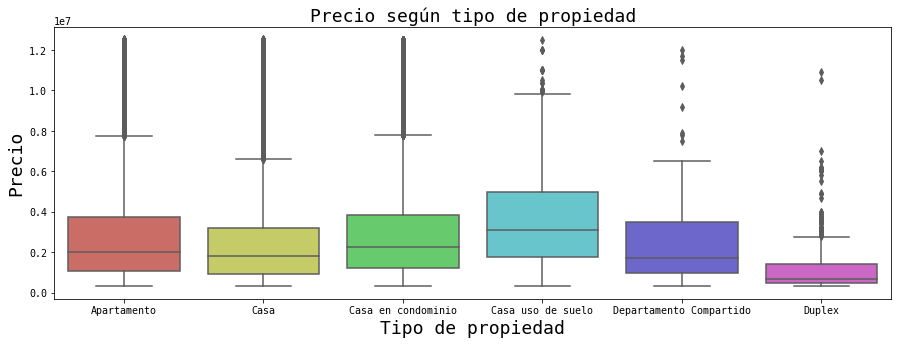

In [44]:
get_boxplot(publicaciones_viviendas, 'tipodepropiedad', 'precio', (15,5), label_x='Tipo de propiedad', label_y='Precio', title='Precio según tipo de propiedad')

Tener en cuenta que la escala de precios es 1e7, por lo tanto 0.2 es 2,000,000.00.
A simple vista los apartamentos, las casas y las casas en condominio tienen precios similares (en promedio).
El problema de este análisis es que no se tiene en cuenta que existen otros factores que podrían variar el precio, por ejemplo los metros cuadrados. Es decir si una casa y un apartamento tienen metros cuadrados similares, ¿El precio también es similar?.

### Relación entre tipo de propiedad, metros cuadrados y precio

Primero verifiquemos que todas las propiedades tienen los valores de metros cuadrados.

In [11]:
publicaciones_viviendas.isnull().sum()

tipodepropiedad                    0
id                                 0
titulo                          5054
descripcion                     1458
direccion                      47522
ciudad                           330
provincia                        143
antiguedad                     34858
habitaciones                    4760
garages                        31185
banos                          10918
metroscubiertos                 8054
metrostotales                  46972
idzona                         25836
lat                           113502
lng                           113502
fecha                              0
gimnasio                           0
usosmultiples                      0
piscina                            0
escuelascercanas                   0
centroscomercialescercanos         0
precio                             0
mes                                0
ano                                0
dia                                0
dtype: int64

In [12]:
publicaciones_viviendas.loc[(publicaciones_viviendas['metroscubiertos'].isnull()) & (publicaciones_viviendas['metrostotales'].isnull())]

,tipodepropiedad,id,titulo,descripcion,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia


Como se observa hay publicaciones que no tienen los metros cuadrados cubiertos o bien no tienen los metros cuadrados totales, pero no hay ninguna que no tenga ninguno de los 2 datos. Esto podría indicar que en caso que los metros totales estén en null, significa que los metros cubiertos son los metros totales y viceversa. Para no dejar fuera del análisis estas publicaciones consideraremos que lo dicho anteriormente es cierto, por lo tanto actualizaremos los valores.

In [13]:
publicaciones_viviendas.loc[publicaciones_viviendas['metroscubiertos'].isnull(), ['metroscubiertos']] = publicaciones_viviendas['metrostotales']
publicaciones_viviendas.loc[publicaciones_viviendas['metrostotales'].isnull(), ['metrostotales']] = publicaciones_viviendas['metroscubiertos']
#Verificamos que no haya valores en 0
publicaciones_viviendas.loc[publicaciones_viviendas['metrostotales'] == 0]

,tipodepropiedad,id,titulo,descripcion,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia


Ahora que todas las propiedades tienen valores en el campo metros cuadrados es necesario determinar un rango de análisis. Análiamos con un histograma en qué rangos se encuentran aproximadamente la mayor cantidad de publicaciones.

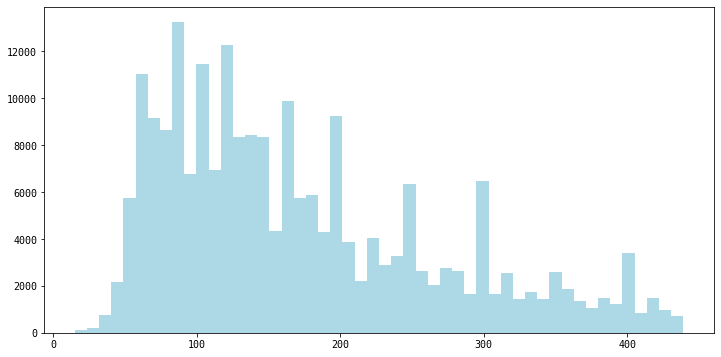

In [15]:
get_hist(publicaciones_viviendas["metrostotales"], bins=50)

Para que la cantidad de muestras entre los distintos tipos de propiedades sea similar vamos a tomar el rango 120 a 130

In [16]:
publicaciones_entre_120_y_130 = publicaciones_viviendas.loc[(publicaciones_viviendas["metrostotales"] >= 120) & (publicaciones_viviendas["metrostotales"] <= 130)]
publicaciones_entre_120_y_130.groupby("tipodepropiedad").agg({"id":"count"})

,id
tipodepropiedad,
Apartamento,3626
Casa,11245
Casa en condominio,1442
Casa uso de suelo,38
Departamento Compartido,11
Duplex,16


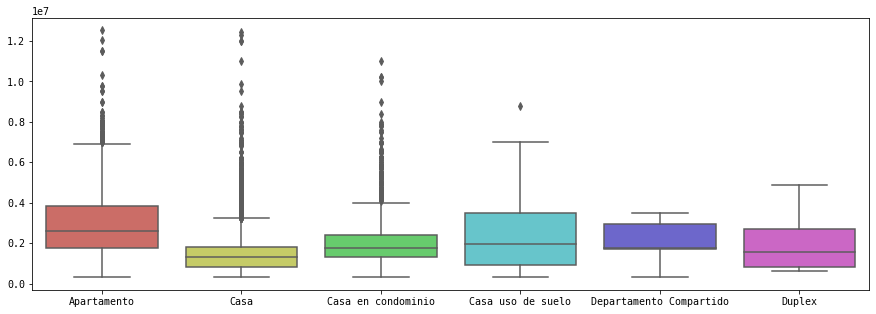

In [17]:
get_boxplot(publicaciones_entre_120_y_130, 'tipodepropiedad', 'precio', (15,5))

De este gráfico sólo podemos considerar válidos los datos de departamentos, casas y casas en condominio, dado que la cantidad de muestras de los demás tipos de propiedades no es representativo.
Si consideramos propiedades de metros similares vemos que los departamentos son más caros. Entonces por qué en el gráfico anterior mostraba que las casas y los departamentos tienen precios similares y aquí no ocurre eso? Es de suponer que la casas tienen más metros cuadrados que los departamentos en general, por lo tanto si tomamos las propiedades sin limitar las demás características las casas tienden a tener precios similares a los departamentos por la cantidad de metros cuadrados. Lo anterior se puede verificar con el siguiente gráfico.

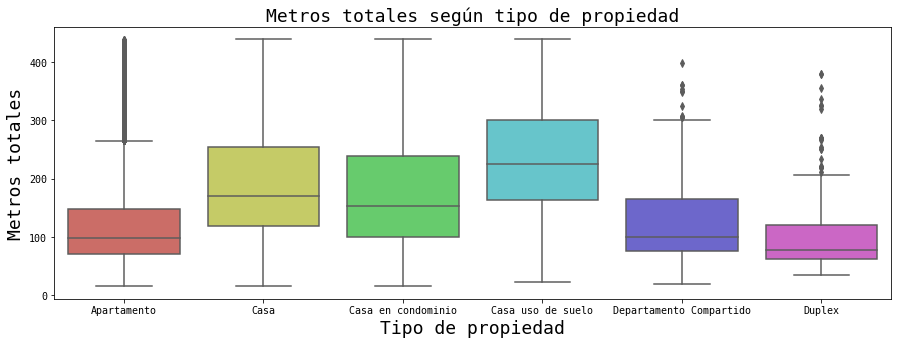

In [18]:
get_boxplot(publicaciones_viviendas, 'tipodepropiedad', 'metrostotales', (15,5), title="Metros totales según tipo de propiedad", label_x="Tipo de propiedad", label_y="Metros totales")

En el siguiente gráfico se puede observar el cambio de precio según la cantidad de metros cuadrados, por tipo de propiedad.

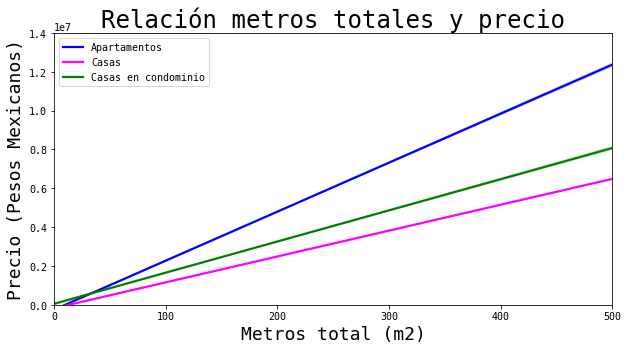

In [48]:
publicaciones_apartamentos = publicaciones_viviendas.loc[publicaciones_viviendas['tipodepropiedad'] == 'Apartamento']
publicaciones_casas = publicaciones_viviendas.loc[publicaciones_viviendas['tipodepropiedad'] == 'Casa']
publicaciones_casas_condominio = publicaciones_viviendas.loc[publicaciones_viviendas['tipodepropiedad'] == 'Casa en condominio']
f, ax = plt.subplots(figsize=(10,5))
ax.set(xlim=(0, 500), ylim=(0, 14000000))
#sns.scatterplot(x='metrostotales', y='precio', data=publicaciones_viviendas.loc[publicaciones_viviendas['tipodepropiedad'] == 'Apartamento'])
sns.regplot(x=publicaciones_apartamentos['metrostotales'],y=publicaciones_apartamentos['precio'],color='blue',scatter=False)
sns.regplot(x=publicaciones_casas['metrostotales'],y=publicaciones_casas['precio'],color='magenta',scatter=False)
sns.regplot(x=publicaciones_casas_condominio['metrostotales'],y=publicaciones_casas_condominio['precio'],color='green',scatter=False)

plt.legend(labels=['Apartamentos','Casas','Casas en condominio'])
plt.title('Relación metros totales y precio', size=24)
plt.xlabel('Metros total (m2)', size=18)
plt.ylabel('Precio (Pesos Mexicanos)', size=18);